In [1]:
#pip install plotly

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly as py
import plotly.graph_objs as go
import requests
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import *
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
plt.style.use('bmh')

In [3]:
''' 
https://poloniex.com/support/api/ 
https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1414602755&end=9999999999&period=86400 
''' 

' \nhttps://poloniex.com/support/api/ \nhttps://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1414602755&end=9999999999&period=86400 \n'

In [4]:
ret = requests.get('https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1414602755&end=9999999999&period=86400')
ret

<Response [200]>

In [5]:
js = ret.json()
js

[{'date': 1424304000,
  'high': 244,
  'low': 225,
  'open': 225,
  'close': 244,
  'volume': 46.27631267,
  'quoteVolume': 0.19311748,
  'weightedAverage': 239.62777823},
 {'date': 1424390400,
  'high': 245,
  'low': 240.25,
  'open': 240.25011809,
  'close': 240.25,
  'volume': 55.894897,
  'quoteVolume': 0.23042935,
  'weightedAverage': 242.56847926},
 {'date': 1424476800,
  'high': 245,
  'low': 245,
  'open': 245,
  'close': 245,
  'volume': 14.72223865,
  'quoteVolume': 0.06009077,
  'weightedAverage': 245},
 {'date': 1424563200,
  'high': 249,
  'low': 235,
  'open': 245,
  'close': 235,
  'volume': 129.12124785,
  'quoteVolume': 0.53905499,
  'weightedAverage': 239.53260845},
 {'date': 1424649600,
  'high': 235.001,
  'low': 235,
  'open': 235.00000236,
  'close': 235,
  'volume': 96.56756248,
  'quoteVolume': 0.41092569,
  'weightedAverage': 235.00006166},
 {'date': 1424736000,
  'high': 239.75,
  'low': 235,
  'open': 235,
  'close': 239.75,
  'volume': 149.15439319,
  'quote

In [6]:
df = pd.DataFrame(js)
df

,date,high,low,open,close,volume,quoteVolume,weightedAverage
0,1424304000,244.000000,225.000000,225.000000,244.000000,4.627631e+01,0.193117,239.627778
1,1424390400,245.000000,240.250000,240.250118,240.250000,5.589490e+01,0.230429,242.568479
2,1424476800,245.000000,245.000000,245.000000,245.000000,1.472224e+01,0.060091,245.000000
3,1424563200,249.000000,235.000000,245.000000,235.000000,1.291212e+02,0.539055,239.532608
4,1424649600,235.001000,235.000000,235.000002,235.000000,9.656756e+01,0.410926,235.000062
...,...,...,...,...,...,...,...,...
1891,1587686400,7605.555556,7397.041200,7551.384364,7502.897565,1.641349e+07,2183.247717,7517.924269
1892,1587772800,7696.659932,7439.124738,7503.323928,7538.715711,1.665867e+07,2208.694648,7542.313014
1893,1587859200,7700.000000,7483.682284,7538.715711,7694.626301,1.703245e+07,2242.789247,7594.317541
1894,1587945600,7788.000000,7624.601700,7694.754048,7773.240743,2.421146e+07,3143.131254,7702.975600


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896 entries, 0 to 1895
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1896 non-null   int64  
 1   high             1896 non-null   float64
 2   low              1896 non-null   float64
 3   open             1896 non-null   float64
 4   close            1896 non-null   float64
 5   volume           1896 non-null   float64
 6   quoteVolume      1896 non-null   float64
 7   weightedAverage  1896 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 118.6 KB


In [8]:
df.describe()

,date,high,low,open,close,volume,quoteVolume,weightedAverage
count,1.896000e+03,1896.000000,1896.000000,1896.000000,1896.000000,1.896000e+03,1896.000000,1896.000000
mean,1.506168e+09,4416.772995,4135.970273,4285.596858,4289.436052,1.441346e+07,2745.342664,4276.497064
std,4.730161e+07,4100.335214,3784.653043,3958.420943,3958.011980,2.852952e+07,5034.624374,3938.936883
min,1.424304e+09,219.010000,99.000000,191.300000,178.719313,0.000000e+00,0.000000,207.450144
25%,1.465236e+09,578.785248,558.775000,565.951029,567.546399,1.067740e+05,166.520934,570.864506
50%,1.506168e+09,3678.736151,3531.447981,3602.654999,3607.242660,3.775643e+06,806.575821,3602.468760
75%,1.547100e+09,7601.388889,7237.957864,7396.582244,7406.250000,1.665971e+07,3036.607967,7404.640173
max,1.588032e+09,19903.440214,18569.637853,19223.000000,19223.000000,3.960385e+08,48896.616808,19236.130652


In [9]:
price = df['close'].values.tolist()
price

[244.0,
 240.25,
 245.0,
 235.0,
 235.0,
 239.75,
 237.75,
 238.5,
 249.0,
 240.00006025,
 251.0,
 269.0,
 267.21999999,
 280.0,
 257.00012,
 260.0,
 260.00000522,
 260.00003101,
 264.00000533,
 291.0,
 276.00000001,
 276.00000112,
 275.11000009,
 275.10000036,
 282.10800036,
 275.0,
 275.00000003,
 262.09000001,
 264.84631516,
 263.56083094,
 263.19298262,
 267.51684843,
 260.67351138,
 242.52550736,
 247.47551488,
 242.5255,
 253.3527,
 248.72849578,
 247.96933001,
 254.35279355,
 249.33852966,
 249.0,
 255.0,
 255.0,
 254.42717667,
 254.69622183,
 254.69622183,
 253.116,
 248.28703147,
 269.0,
 236.195,
 234.8725,
 232.05,
 245.99999987,
 219.90926541,
 225.1293,
 229.57789808,
 223.48807719,
 221.5,
 223.57789808,
 223.57789808,
 229.7512,
 230.5666,
 231.55429753,
 235.0896,
 223.57789808,
 212.1681,
 219.01,
 227.0,
 227.0,
 241.997374,
 233.1665,
 235.0,
 239.4042,
 233.99829863,
 231.0154,
 225.0,
 225.0,
 249.53240001,
 238.5565,
 246.25,
 241.1937,
 244.90444044,
 239.3998875

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['close']] = scaler.fit_transform(df[['close']])  # 0~1로 정규화
df.describe

<bound method NDFrame.describe of             date         high          low         open     close  \
0     1424304000   244.000000   225.000000   225.000000  0.003428   
1     1424390400   245.000000   240.250000   240.250118  0.003231   
2     1424476800   245.000000   245.000000   245.000000  0.003480   
3     1424563200   249.000000   235.000000   245.000000  0.002955   
4     1424649600   235.001000   235.000000   235.000002  0.002955   
...          ...          ...          ...          ...       ...   
1891  1587686400  7605.555556  7397.041200  7551.384364  0.384587   
1892  1587772800  7696.659932  7439.124738  7503.323928  0.386468   
1893  1587859200  7700.000000  7483.682284  7538.715711  0.394654   
1894  1587945600  7788.000000  7624.601700  7694.754048  0.398782   
1895  1588032000  7777.902604  7726.992075  7776.851464  0.397163   

            volume  quoteVolume  weightedAverage  
0     4.627631e+01     0.193117       239.627778  
1     5.589490e+01     0.230429    

In [15]:
price = df['close'].values.tolist()
price

[0.0034278368698297933,
 0.0032309273586996947,
 0.0034803460727978203,
 0.0029552540431175573,
 0.0029552540431175573,
 0.003204672757215681,
 0.003099654351279629,
 0.00313903625350565,
 0.003690382884669925,
 0.003217803221637167,
 0.003795401290605977,
 0.004740566944030449,
 0.004647100562222272,
 0.005318168176678739,
 0.004110462809518489,
 0.004267984117318213,
 0.0042679843914162525,
 0.004267985745628597,
 0.004478021209064372,
 0.0058957694093270275,
 0.005108131365331727,
 0.00510813142361694,
 0.005061398178890919,
 0.005060873101038725,
 0.005428857595438652,
 0.005055622161838608,
 0.005055622163413884,
 0.00437772835204648,
 0.0045224602637016775,
 0.004454960511881502,
 0.004435645089785174,
 0.004662687837208973,
 0.004303349663071908,
 0.003350412436521174,
 0.0036103333860821093,
 0.0033504120500534394,
 0.003918939692428852,
 0.00367612641447527,
 0.00363626322497196,
 0.003971453807632816,
 0.0037081588072975617,
 0.003690382884669925,
 0.004005438102478082,
 0.00

Rnn layer
    - M to 1
    - M to M
    input이 1개가 아니라서 아래 2개는 X
    - 1 to M 
    - 1 to 1
    
X(train) > (sample 개수, 5, 1) : 5일치 data를 가지고 1개를 출력 <br>
Y(target) > (sample 개수, 1)<br>
5일 > 당일 (or 내일)<br>

In [20]:
window_size = 5 # 5일치
X = []
Y = []
# 전체 data에서 이동하면 제일 마지막에는 이동할 공간이 없다.
# 그래서 제일 끝까지 for를 돌리는 게 아니라 범위의 끝이 data 끝에 닿으면 끝나게 한다.
for i in range(len(price) - window_size): 
    # i = 0
    # j = 0~4 (5개)
    # X.append([price[i + j] for j in range(window_size)]) 아래랑 같음 
    X.append(price[ i : i + window_size ])  # X[0,1,2,3,4]
    Y.append(price[ i + window_size ])  # Y[5]

In [28]:
X = np.array(X)
print(X.shape)  # 5 : 5일, sequence
X

(1891, 5)


array([[0.00342784, 0.00323093, 0.00348035, 0.00295525, 0.00295525],
       [0.00323093, 0.00348035, 0.00295525, 0.00295525, 0.00320467],
       [0.00348035, 0.00295525, 0.00295525, 0.00320467, 0.00309965],
       ...,
       [0.34993273, 0.36470923, 0.38722078, 0.38458676, 0.38646754],
       [0.36470923, 0.38722078, 0.38458676, 0.38646754, 0.39465429],
       [0.38722078, 0.38458676, 0.38646754, 0.39465429, 0.39878227]])

In [29]:
Y = np.array(Y)
print(Y.shape)
Y

(1891,)


array([0.00320467, 0.00309965, 0.00313904, ..., 0.39465429, 0.39878227,
       0.39716283])

In [ ]:
# train : 학습용
# validation : 모델이 맞는지, 잘 만들어 졌는지 검증하는 것
# test : 학습 & 검증 때 쓰지 않은 data를 넣어서 테스트 하는 것 > 지금까지는 data 적어서 같이 쓴 것

In [34]:
train_test_split = 1500
X_train = X[: train_test_split, :]
Y_train = Y[: train_test_split]
X_test = X[train_test_split : , :]
Y_test = Y[train_test_split : ]

In [35]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1500, 5)
(1500,)
(391, 5)
(391,)


In [38]:
# reshape : 이전과 data 개수가 같아야 함
# expand_dims : data 개수가 달라도 됨

# 아래 2 코드 같음
# X_train = np.reshape(X_train, (X_train.shape[0], window_size, 1))
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

In [46]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_train[0].shape)

(1500, 5, 1)
(1500,)
(391, 5, 1)
(391,)
(5, 1)


In [62]:
# Create Model
# LSTM > Dense : regression이라서 classification 필요 없음

# LSTM이 1개 더 있을거면 위에거엔 return_sequence=True / 아래는 False


i = Input(shape = (X_train[0].shape))
x = LSTM(128)(i)
x = Dense(1)(x)  # default : linear
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam())
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 5, 1)]            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.fit(X_train, Y_train, epochs=50, batch_size=1)

Train on 1500 samples
Epoch 1/50
1500/1500 [==============================] - 5s 3ms/sample - loss: 0.0015
Epoch 2/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 8.3748e-04
Epoch 3/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 6.9556e-04
Epoch 4/50
1500/1500 [==============================] - 4s 2ms/sample - loss: 5.5416e-04
Epoch 5/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 5.0613e-04
Epoch 6/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 4.1764e-04
Epoch 7/50
1500/1500 [==============================] - 4s 2ms/sample - loss: 3.8186e-04
Epoch 8/50
1500/1500 [==============================] - 4s 2ms/sample - loss: 3.2840e-04
Epoch 9/50
1500/1500 [==============================] - 4s 2ms/sample - loss: 3.7007e-04
Epoch 10/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 2.8060e-04
Epoch 11/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 3.4012e-04
E

In [64]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

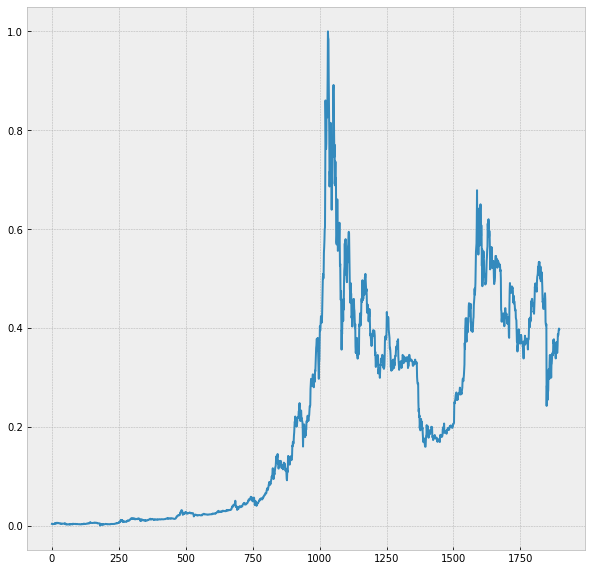

In [65]:
plt.figure(figsize=(10,10))
plt.plot(price)

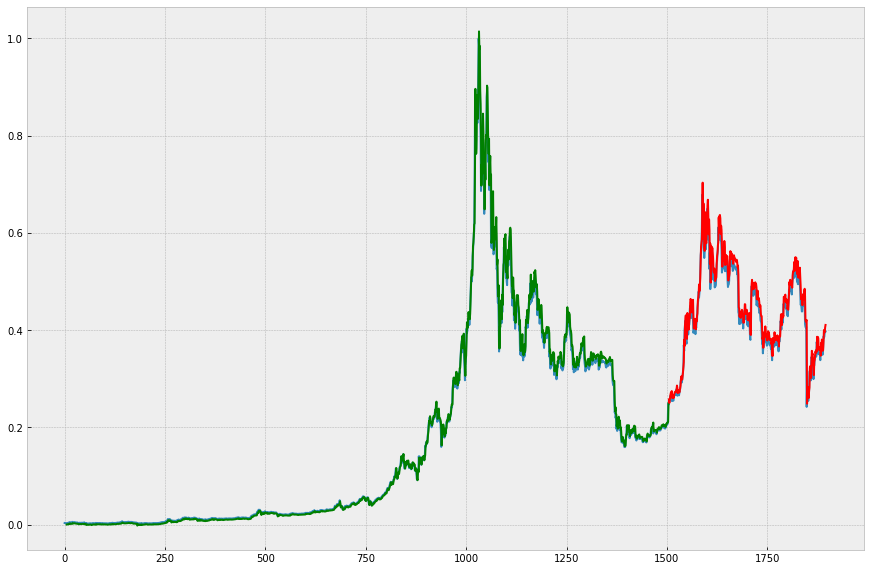

In [66]:
plt.figure(figsize=(15,10))
plt.plot(price)

split_pt = train_test_split + window_size #1500+50

#train graph
plt.plot(np.arange(window_size, split_pt,1), train_predict, color='g')

#prediction graph
plt.plot(np.arange(split_pt, split_pt + len(test_predict), 1), test_predict, color='r')

In [67]:
'''
plt.figure(figsize=(15,10))
plt.plot(price)

split_pt = train_test_split + window_size #1500+50

#train graph
plt.plot(np.arange(window_size, split_pt,1), train_predict, color='g')

#prediction graph
plt.plot(np.arange(split_pt, split_pt + len(test_predict), 1), test_predict, color='r')
'''

trace1 = go.Scatter(x = np.arange(window_size, split_pt,1),
                   y = train_predict.reshape(1500),
                   mode='lines', name='train')

trace2 = go.Scatter(x = np.arange(split_pt, split_pt + len(test_predict), 1),
                   y = test_predict.reshape(391),
                   mode='lines', name='test')

trace_original = go.Scatter(x = np.arange(1, len(price), 1),
                   y = price,
                   mode='lines', name='original')

data = [trace1, trace2, trace_original]
py.offline.plot(data)

'temp-plot.html'

## prediction

In [68]:
train_predict[390]

array([0.00944105], dtype=float32)

In [70]:
print("X_test[390] : ", X_test[390])
print("test_predict[390] : ", test_predict[390])

X_test[390] :  [[0.38722078]
 [0.38458676]
 [0.38646754]
 [0.39465429]
 [0.39878227]]
test_predict[390] :  [0.41075283]


In [75]:
scaler.inverse_transform(test_predict)  # 정규화 한 것을 원래 값으로 되돌림 

array([[ 5085.3325],
       [ 4946.545 ],
       [ 5065.455 ],
       [ 5165.7495],
       [ 5283.973 ],
       [ 5354.6177],
       [ 5261.7114],
       [ 5410.6396],
       [ 5146.701 ],
       [ 5136.541 ],
       [ 5172.4375],
       [ 5248.71  ],
       [ 5145.9385],
       [ 5276.7207],
       [ 5329.3315],
       [ 5373.618 ],
       [ 5372.941 ],
       [ 5402.722 ],
       [ 5375.589 ],
       [ 5481.2217],
       [ 5627.1953],
       [ 5535.223 ],
       [ 5329.1606],
       [ 5419.35  ],
       [ 5436.529 ],
       [ 5435.4116],
       [ 5358.1846],
       [ 5435.147 ],
       [ 5526.3804],
       [ 5629.1206],
       [ 5906.021 ],
       [ 5988.8354],
       [ 5896.329 ],
       [ 5860.948 ],
       [ 5986.5195],
       [ 6140.8926],
       [ 6332.773 ],
       [ 6544.18  ],
       [ 7422.8213],
       [ 7176.364 ],
       [ 7989.0034],
       [ 8249.896 ],
       [ 8376.705 ],
       [ 8050.355 ],
       [ 7512.4277],
       [ 7454.2812],
       [ 8469.813 ],
       [ 8193

In [74]:
import tensorflow as tf
tf.__version__

'2.1.0'